In [2]:
import numpy as np
import pandas as pd
import cv2 
import os
import torch
import glob

In [3]:
train_path = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'

In [4]:
ids = os.listdir(train_path)

load a sample image 

In [5]:
demo_array = np.load(train_path+'/'+ids[0]+'/band_14.npy')

In [6]:
import matplotlib.pyplot as plt

In [7]:
demo_array.shape

(256, 256, 8)

In [8]:
print(demo_array)

[[[275.972   269.6549  275.0543  ... 269.90686 265.98557 269.74213]
  [277.10178 268.98615 273.99417 ... 277.9687  271.73135 276.54315]
  [271.3543  268.3787  274.7878  ... 283.38953 278.08224 279.68307]
  ...
  [255.24178 277.82028 286.86563 ... 290.17252 290.26688 290.28073]
  [244.12544 266.9112  286.0609  ... 290.37332 290.2329  290.30472]
  [241.77351 258.89825 281.68927 ... 290.36966 290.2385  290.197  ]]

 [[279.90118 266.13345 278.66357 ... 270.49176 270.45108 275.96533]
  [278.88654 265.50912 279.45218 ... 276.43408 278.40326 281.31058]
  [271.43628 265.0655  279.51178 ... 280.9422  284.30286 284.1082 ]
  ...
  [262.9256  283.69894 287.0772  ... 290.18735 290.21524 290.2001 ]
  [252.94093 274.95422 287.60825 ... 290.34183 290.29736 290.29596]
  [247.2548  265.0006  284.25638 ... 290.4245  290.30356 290.24826]]

 [[280.98557 269.6363  273.53983 ... 276.9333  272.07925 278.29608]
  [278.41254 269.43253 276.79544 ... 281.99072 280.63754 282.50784]
  [270.6028  267.13113 278.271  

In [9]:
fig1 = demo_array[:,:,0]

In [10]:
fig1.shape

(256, 256)

In [11]:
fig2 = demo_array[:,:,1]

In [12]:
fig_n = demo_array[:,:,7]

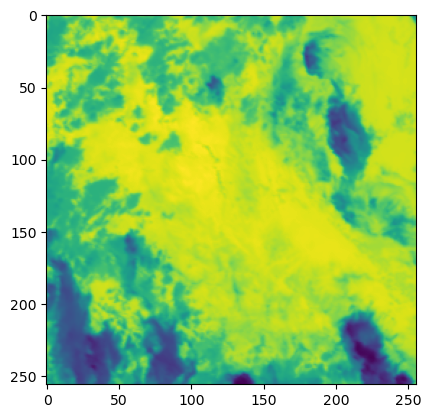

In [13]:
plt.imshow(fig1)
plt.show()

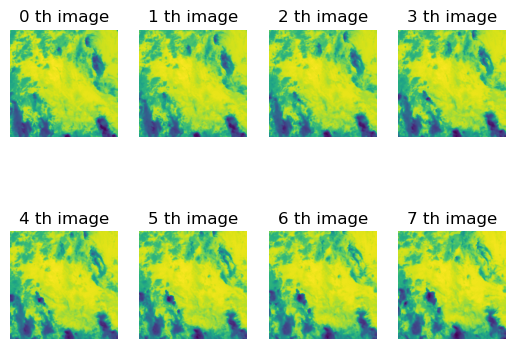

In [14]:
ax , plot = plt.subplots(2,4)
for idx1,sub_fig in enumerate(plot):
    for idx , fig in enumerate(sub_fig):
        fig.imshow(demo_array[:,:,idx+4*idx1])
        fig.axis('off')
        fig.set_title(f'{idx+4*idx1} th image')
       

convert images to ash colour fromat 

In [15]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

In [28]:
os.mkdir('/kaggle/input/data_dir')

['lib', 'input', 'working', 'data_dir']

In [44]:
for i in ids:
    band15= np.load(f'{train_path}/{i}/band_15.npy')
    band14= np.load(f'{train_path}/{i}/band_14.npy')
    band11= np.load(f'{train_path}/{i}/band_11.npy')
    r= normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g= normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b= normalize_range(band14, _T11_BOUNDS)
    image = np.clip((np.stack([r,g,b],axis=2)),0,1)
    image = image[...,4]
    mask=np.load(f'{train_path}/{i}/human_pixel_masks.npy')
#     os.mkdir(f'/kaggel/data_dir/{i}')
    directory = f'/kaggle/data_dir/{i}/'
    os.makedirs(directory, exist_ok=True)
    np.save(os.path.join(directory, 'false.npy'), image)
    np.save(os.path.join(directory, 'mask.npy'), mask)

In [45]:
tmp = os.listdir('/kaggle/data_dir')

In [55]:
test_image = np.load(f'/kaggle/data_dir/{tmp[156]}/false.npy')
test_mask = np.load(f'/kaggle/data_dir/{tmp[156]}/mask.npy')
print(test_image.shape)
print(test_mask.shape)

(256, 256, 3)
(256, 256, 1)


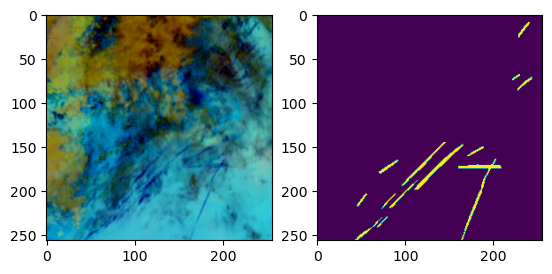

In [56]:
fig , ax = plt.subplots(1,2)
ax[0].imshow(test_image)
ax[1].imshow(test_mask)

custom model input 256,256,3 -> output 256,256

In [73]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as C
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
!pip install -q torchsummary
from torchvision import models
from torchsummary import summary

In [87]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.ids = os.listdir(self.path)
    def __len__(self):
        return len(self.ids)
    def __getitem__(self,idx):
        id = ids[idx]
        image = np.load(f'{self.path}/{id}/false.npy')
        mask = np.load(f'{self.path}/{id}/mask.npy')
        image = torch.from_numpy(image)
        image = torch.moveaxis(image,-1,0)
        mask = torch.from_numpy(mask)
        mask=torch.moveaxis(mask,-1,0)
        return image,mask.float()

In [88]:
train_dataset = CustomDataset('/kaggle/data_dir')

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:709: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.array(x, subok=True, copy=copy)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

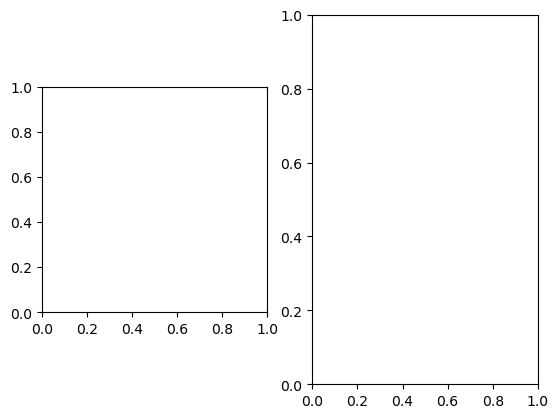

In [92]:
test_image = train_dataset.__getitem__(3)
test_mask = train_dataset.__getitem__(3)
# print(test_image.shape)
# print(test_mask.shape)
ax , fig = plt.subplots(1,2)
fig[0].imshow(test_image)
fig[1].imshow(test_mask)

In [93]:
train_dataloader = DataLoader(train_dataset,batch_size=64, shuffle=True)

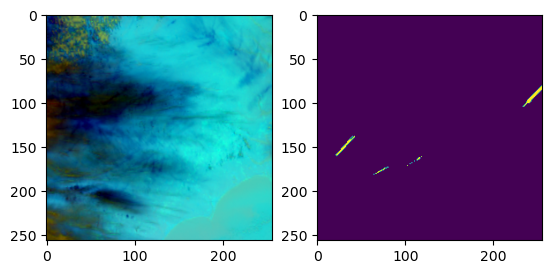

In [103]:
test_image , test_mask = next(iter(train_dataloader))
test_image = torch.moveaxis(test_image,1,-1)
test_mask = torch.moveaxis(test_mask,1,-1)
ax , fig = plt.subplots(1,2)
fig[0].imshow(test_image[2])
fig[1].imshow(test_mask[2])

In [82]:
model = smp.Unet(encoder_name='resnet34',encoder_weights='imagenet',in_channels=3,classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 134MB/s] 


In [86]:
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
def dice_loss(ground,pred):
    